# Predictive Model

The purpose of this part based on this mentality behind:
**Treat your customers in a way they deserve before they expect that (e.g., LTV prediction) and act before something bad happens (e.g., churn)**

Predictive analytics helps us a lot on this one. One of the many opportunities it can provide is predicting the next purchase products of the customer. What if we know if a customer is likely to by that products in next purchase?

We can build our strategy on top of that and come up with lots of tactical actions like:
* No promotional offer to this products since s/he will make a purchase anyways
* Nudge the products with inbound marketing if there is no purchase products in the predicted order compared to the projection

In this part, we will be using Instacrat Dataset and follow the steps below:

## 1. Objectives
The objective of this part is to predict which previously purchased products will be in a user’s next order.

## 2. Problem Definition
Instacart dataset conclude the data as prior, train or test. Prior orders describe the past behaviour of a user while train and test orders regard the future behaviour that we need to predict. As our objective define, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). The problem is described as the firgue below:

![problem](..\img\problem.PNG)

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. As our mission we need to come up and calculate various predictor variables (X) that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

![predict_framework](..\img\predict_framework.PNG)

## 3. Import and Data Processing

### 3.1 Import packages

In [1]:
# For data manipulation
import pandas as pd         
import numpy as np


# Garbage Collector to free up memory
import gc                         
gc.enable()    # Activate 

### 3.2 Load the csv files

In [2]:
orders = pd.read_csv('orders.csv')
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### 3.3 Convert character varibales into category

In [8]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

### 3.4 Merge 'orders' with 'orders_products_prior' on Innner

In [9]:
# Merge the orders with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both dataframes
prior = orders.merge(order_products_prior, on='order_id', how='inner')
prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


This prior table contains for all the customers (user_id):
*  the orders (order_id) that they have placed accompanied with
*  the products (product_id) that have been bought in each order

## 4. Create Predictor variables - X (based on prior table)

We identify and calculate predictor variables based on the prior table. As well as we can create various types of predictors like:

* **User predictors** : the behavior of a user e.g. total number of orders of a user.
* **Product predictors** : characteristics of a product e.g. total number of times a product has been purchased, total products has been purchased in an order
* **User & product predictors** : the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

### 4.1 User predictors

After deep dive into prior table, we decide to create two user predictors:
* 4.1.1 Number of orders per customer
* 4.1.2 How frequent a customer has reordered products

#### 4.1.1 Number of orders per customer

In [10]:
# First group by user_id, then identify the highest order number in each group, save the new column to a DataFrame
user = prior.groupby('user_id')['order_number'].max().to_frame('u_total_orders')

# Reset the index of the table so to bring user_id from index to column
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


#### 4.1.2 How frequent a customer has reordered products

This predictor feature is a ratio which shows for each user in what extent has products that have been reordered in the past:
So we create the following ratio:

![user_1](..\img\user_1.PNG)

E.g: for a user that has ordered 8 products in total, where 3 times were reorders, the ratio will be:

![user_2](..\img\user_2.PNG)

In [11]:
# To create the above ratio we groupby() prior table by each user and then calculate the mean of reordered
u_reorder = prior.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')

# Reset the index of the table so to bring user_id from index to column
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [12]:
# Merge two user predictor into one table

user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


### 4.2 Product predictors

Similar to user predictors, we decide to create three product predictors:
* 4.2.1 Number of purchases for each product
* 4.2.2 What is the probability for a product to be reordered
* 4.2.3 The position of add-to-cart

#### 4.2.1 Number of purchases for each product

We calculate the total number of purchases for each product. We create a product DataFrame to store the results.

In [13]:
# First create group by product_id, then count the orders, save the result for each product to a new DataFrame  
product = prior.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')

# Reset the index of the table so to bring product_id rom index to column
product = product.reset_index()
product.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


#### 4.2.2 What is the probability for a product to be reordered

We want to find the products which have the highest probability of being reordered. Towards this end it is necessary to define the probability as below:

![user_3](..\img\user_3.PNG)

Eg: The product with product_id=3 is included in 277 purchases but only 20 are reorders. So we have the ratio:

![user_4](..\img\user_4.PNG)

First, remove products with less than 40 purchases - Filter with .shape[[0]] mean the number of rows in order to the calculation of the afore mentioned ratio to be meaningful.

In [14]:
# the x on lambda function is a temporary variable which represents each group
p_reorder = prior.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [15]:
# To create the above ratio we groupby() prior table by each product and then calculate the mean of reordered
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')

# Reset the index of the table so to bring user_id from index to column
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


#### 4.2.3 The position of add-to-cart

In [16]:
Addtocart=prior.groupby('product_id')['add_to_cart_order'].mean().to_frame('position_to_cart')
Addtocart = Addtocart.reset_index()

Addtocart.head()

,product_id,position_to_cart
0,1,5.801836
1,2,9.888889
2,3,6.415162
3,4,9.507599
4,5,6.466667


In [17]:
# Merge product with p_reorder into one table

product = product.merge(p_reorder, on='product_id', how='left')

# delete the reorder table
del p_reorder
gc.collect()

product.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


In [18]:
# Merge the product table with Addtocart
product = product.merge(Addtocart, on='product_id',how='left')

# delete the Addtocart df
del Addtocart
gc.collect()
product.head()

,product_id,p_total_purchases,p_reorder_ratio,position_to_cart
0,1,1852,0.613391,5.801836
1,2,90,0.133333,9.888889
2,3,277,0.732852,6.415162
3,4,329,0.446809,9.507599
4,5,15,NaN,6.466667


As we performed a left join with product DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value. So, we have to fill NaN values

In [19]:
product['p_reorder_ratio'] = product['p_reorder_ratio'].fillna(value=0)
product.head()

,product_id,p_total_purchases,p_reorder_ratio,position_to_cart
0,1,1852,0.613391,5.801836
1,2,90,0.133333,9.888889
2,3,277,0.732852,6.415162
3,4,329,0.446809,9.507599
4,5,15,0.000000,6.466667


### 4.3 User-Product pair predictors

We create the following predictors:

* 4.3.1 How many times a user bought a product
* 4.3.2 How frequently a customer bought a product after its first purchase
* 4.3.3 How many times a customer bought a product on its last 5 orders

#### 4.3.1 How many times a user bought a product

In [20]:
# Create distinct groups for each pair of user and product, count orders, save the result for each user X product to a new DataFrame 
up = prior.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('up_total_bought')

# Reset the index of the table so to bring user_id & product_id rom indices to columns
up = up.reset_index()
up.head()

,user_id,product_id,up_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


#### 4.3.2 How frequently a customer bought a product after its first purchase

This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to a buy it (starting from her first purchase of the product)

![user_5](..\img\user_5.PNG)

Eg: We examine the use with user_id:1 and the product with product_id:13032. **User 1 has made 10 orders in total. She has bought the product 13032 for first time in her 2nd order and she has bought the same product 3 times in total. The user was able to buy the product 9 times** (starting from her 2nd order until her last order). As a result, **she has bought it 3 out of 9 times, meaning reorder_ratio = 3/9 = 0,333**


Let's calculate this predictor feature:

Firstly, we calculate the total time a user bought a product

In [21]:
# First calculate the total time a user bought a product by simply group by user_id, product_id then count the total order_id

times = prior.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['times_bought']
times.head()

times_bought
user_id product_id              
1       196                   10
        10258                  9
        10326                  1
        12427                 10
        13032                  3

Secondly, we calculate the total order placed since the first user's order of a product by finding the two sub-metrics: **total_orders** & **first_order_no**

In [22]:
# Calculate total orders by group by user_id then specify the max number of order number
total_orders = prior.groupby('user_id')['order_number'].max().to_frame('total_orders')

total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [23]:
# Calculate first order number by group by user_id, product_id then specify the min number of order number
first_order_no = prior.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [24]:
# Merge total_order with first_order_number with right join to keep product_id
order_since_first = pd.merge(total_orders, first_order_no, on='user_id', how='right')

order_since_first.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [25]:
# Calculate the total order placed since the first user's order of a product: order_range (of course including the first order of a product)
order_since_first['order_range'] = order_since_first.total_orders - order_since_first.first_order_number + 1

order_since_first.head()

,user_id,total_orders,product_id,first_order_number,order_range
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


Finally, calculate the ratio: How frequently a customer bought a product after its first purchase

In [26]:
# Merge times_bought with order_range
up_ratio = pd.merge(times, order_since_first, on=['user_id', 'product_id'], how='left')

# Calculate the ratio, name it up_reorder_ratio
up_ratio['up_reorder_ratio'] = up_ratio.times_bought / up_ratio.order_range

up_ratio.head()

,user_id,product_id,times_bought,total_orders,first_order_number,order_range,up_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [27]:
# We just need the user_id, product_id and up_reorder_ratio cols, so drop the other cols
up_ratio = up_ratio.drop(['times_bought', 'total_orders', 'first_order_number', 'order_range'], axis=1)

up_ratio.head()

,user_id,product_id,up_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [28]:
# Remove temporary DataFrames
del [times, first_order_no, order_since_first]

In [29]:
# Merge second predictor with the first one before move to the final feature
up = up.merge(up_ratio, on=['user_id', 'product_id'], how='left')

del up_ratio
up.head()

,user_id,product_id,up_total_bought,up_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


#### 4.3.3 How many times a customer bought a product on its last 5 orders

For this feature, we want to keep the last five orders for each customer and get how many times bought any product on them. To achieve this we need to calculate this ratio:

![user_6](..\img\user_6.PNG)

To calculate this ratio, firtsly create a new variable ('order_number_reverse') which keeps the order_number for each order in reverse order

In [30]:
# With .transform(max) we request to get the highest number of the column order_number for each group user_id
prior['order_number_reverse'] = prior.groupby('user_id')['order_number'].transform(max) - prior.order_number +1

prior.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_reverse
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,9
6,2398795,1,prior,2,3,7,15.0,10258,2,0,9
7,2398795,1,prior,2,3,7,15.0,12427,3,1,9
8,2398795,1,prior,2,3,7,15.0,13176,4,0,9
9,2398795,1,prior,2,3,7,15.0,26088,5,1,9


Secondly we keep only last five orders for each customer

In [31]:
last_5_orders = prior[prior.order_number_reverse <= 5]
last_5_orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_reverse
29,3367565,1,prior,6,2,7,19.0,196,1,1,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,5
33,550135,1,prior,7,1,9,20.0,196,1,1,4
34,550135,1,prior,7,1,9,20.0,10258,2,1,4
35,550135,1,prior,7,1,9,20.0,12427,3,1,4
36,550135,1,prior,7,1,9,20.0,25133,4,1,4
37,550135,1,prior,7,1,9,20.0,13032,5,1,4
38,3108588,1,prior,8,1,14,14.0,12427,1,1,3


Then, we perform a .groupby( ) on user_id & product_id. With .count( ) we get how many times each customer bought a product.

In [32]:
last_five = last_5_orders.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last_5']
last_five.head(10)

times_last_5
user_id product_id              
1       196                    5
        10258                  5
        12427                  5
        13032                  2
        25133                  5
        35951                  1
        38928                  1
        39657                  1
        46149                  3
        49235                  2

In [33]:
# Merge the final features with the first two predictor features
up = up.merge(last_five, on=['user_id', 'product_id'], how='left')

del last_five

# fill NaN values
up = up.fillna(0)
up.head()


,user_id,product_id,up_total_bought,up_reorder_ratio,times_last_5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,0.0
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


### 4.4 Merge all predictor variables - X

#### 4.4.1 Merge up (user & product) with user DataFrame with a left join

In [34]:
# Merge up features with the user features
data = up.merge(user, on='user_id', how='left')

data.head()

,user_id,product_id,up_total_bought,up_reorder_ratio,times_last_5,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,5.0,10,0.694915
1,1,10258,9,1.000000,5.0,10,0.694915
2,1,10326,1,0.166667,0.0,10,0.694915
3,1,12427,10,1.000000,5.0,10,0.694915
4,1,13032,3,0.333333,2.0,10,0.694915


#### 4.4.2 Merge data with product DataFrame with a left join

In [35]:
# Merge up & user features (the dataa DataFrame) with product features
data = data.merge(product, on='product_id', how='left')

data.head()

,user_id,product_id,up_total_bought,up_reorder_ratio,times_last_5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,position_to_cart
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,3.721774
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,4.277492
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,4.191097
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,4.760037
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,5.622767


In [36]:
# del the previous tables we used to create predictor features

del prior, user, product, up
gc.collect()

80

## 5. Modelling

Back to the problem definition, we already have the data, we have to create two more columns which define the type of user (train or test) and the order_id of the future order as mentioned before:

![predict_framework](..\img\predict_framework.PNG)

In [37]:
# Create order_future table to prepate for a merge to data
orders_future = orders.loc[(orders.eval_set=='train'), ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
49,5,train,2196797
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501
115,13,train,1827621
129,14,train,2316178
200,17,train,2180313


In [38]:
# it's time we merged the data and orders_future with a left join on user_id
data = data.merge(orders_future, on='user_id', how='left')

data.head(10)

,user_id,product_id,up_total_bought,up_reorder_ratio,times_last_5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,position_to_cart,eval_set,order_id
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,3.721774,train,1187899.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,4.277492,train,1187899.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,4.191097,train,1187899.0
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,4.760037,train,1187899.0
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,5.622767,train,1187899.0
5,1,13176,2,0.222222,0.0,10,0.694915,379450,0.832555,5.095947,train,1187899.0
6,1,14084,1,0.100000,0.0,10,0.694915,15935,0.810982,5.792595,train,1187899.0
7,1,17122,1,0.166667,0.0,10,0.694915,13880,0.675576,6.257421,train,1187899.0
8,1,25133,8,1.000000,5.0,10,0.694915,6196,0.740155,7.001614,train,1187899.0
9,1,26088,2,0.200000,0.0,10,0.694915,2523,0.539041,6.495838,train,1187899.0


### 5.1 Create train and test dataset

To create train dataset, We keep only the customers who are labelled as "train" at eval_set then merge to order_products_train on the two keys: "product_id" & "order_id with a left join

In [39]:
# Get from order_products_train all the products that the train users bought bought in their future order
data_df = data.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_df.head(10)

,user_id,product_id,up_total_bought,up_reorder_ratio,times_last_5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,position_to_cart,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,3.721774,train,1187899.0,1.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,4.277492,train,1187899.0,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,4.191097,train,1187899.0,NaN
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,4.760037,train,1187899.0,NaN
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,5.622767,train,1187899.0,1.0
5,1,13176,2,0.222222,0.0,10,0.694915,379450,0.832555,5.095947,train,1187899.0,NaN
6,1,14084,1,0.100000,0.0,10,0.694915,15935,0.810982,5.792595,train,1187899.0,NaN
7,1,17122,1,0.166667,0.0,10,0.694915,13880,0.675576,6.257421,train,1187899.0,NaN
8,1,25133,8,1.000000,5.0,10,0.694915,6196,0.740155,7.001614,train,1187899.0,1.0
9,1,26088,2,0.200000,0.0,10,0.694915,2523,0.539041,6.495838,train,1187899.0,1.0


In [40]:
# Fill the NaN values
data_df['reordered'] = data_df['reordered'].fillna(0)

data_df.head(10)

,user_id,product_id,up_total_bought,up_reorder_ratio,times_last_5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,position_to_cart,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,3.721774,train,1187899.0,1.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,4.277492,train,1187899.0,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,4.191097,train,1187899.0,0.0
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,4.760037,train,1187899.0,0.0
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,5.622767,train,1187899.0,1.0
5,1,13176,2,0.222222,0.0,10,0.694915,379450,0.832555,5.095947,train,1187899.0,0.0
6,1,14084,1,0.100000,0.0,10,0.694915,15935,0.810982,5.792595,train,1187899.0,0.0
7,1,17122,1,0.166667,0.0,10,0.694915,13880,0.675576,6.257421,train,1187899.0,0.0
8,1,25133,8,1.000000,5.0,10,0.694915,6196,0.740155,7.001614,train,1187899.0,1.0
9,1,26088,2,0.200000,0.0,10,0.694915,2523,0.539041,6.495838,train,1187899.0,1.0


In [41]:
data_df = data_df.set_index(['user_id', 'product_id'])

# Split train set - test set
X = data_df.iloc[:,:-3]
y = data_df.iloc[:,-1]

# X = X.set_index(['user_id', 'product_id'])
X.head()

up_total_bought  up_reorder_ratio  times_last_5  \
user_id product_id                                                    
1       196                      10          1.000000           5.0   
        10258                     9          1.000000           5.0   
        10326                     1          0.166667           0.0   
        12427                    10          1.000000           5.0   
        13032                     3          0.333333           2.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
1       196                     10           0.694915              35791   
        10258                   10           0.694915               1946   
        10326                   10           0.694915               5526   
        12427                   10           0.694915               6476   
        13032                   10           0.694915               3751   

                    p_reorder_ratio  position_to_cart  
user_id product_id                                     
1       196                0.776480          3.721774  
        10258              0.713772          4.277492  
        10326              0.652009          4.191097  
        12427              0.740735          4.760037  
        13032              0.657158          5.622767

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5.2 Train XGBoost Classifier

In [43]:
X_train.to_csv('X_train.csv')

In [44]:
# Standard Scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [45]:
from numpy import nan

In [46]:
param = {'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss',
 'num_boost_round': 10}

In [47]:
import xgboost as xgb
xgb_cmodel = xgb.XGBClassifier(objective = 'binary:logistic', use_label_encoder= True, base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1, colsample_bynode = 1, colsample_bytree = 0.4, gamma = 0, gpu_id = -1, importance_type = 'gain',interaction_constraints = '', learning_rate = 0.300000012, max_delta_step = 0, max_depth = 5, min_child_weight = 1, missing = nan,monotone_constraints = '()', n_estimators = 100, n_jobs = 4, num_parallel_tree = 1, random_state = 0, reg_alpha = 0, reg_lambda = 1,scale_pos_weight = 1, subsample = 1, tree_method = 'exact', validate_parameters = 1, verbosity = None, eval_metric = 'logloss',num_boost_round = 10)
xgb_cmodel.fit(X_train, y_train)

C:\Users\phuoc.huynhtan\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[16:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_boost_round=10, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
# Get best params
xgb_cmodel.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss',
 'num_boost_round': 10}

In [49]:
# Get model predictions on train set with threshold of 0.21 probability
train_pred = (xgb_cmodel.predict_proba(X_train)[:, 1] >= 0.21).astype(int)
train_pred[:5]

array([0, 1, 0, 0, 0])

In [50]:
# Get model predictions with threshold of 0.21 probability
test_pred = (xgb_cmodel.predict_proba(X_test)[:, 1] >= 0.21).astype(int)
test_pred[:5]

array([0, 0, 1, 0, 0])

In [51]:
# Import evaluation matrices
from sklearn.metrics import f1_score, classification_report
from sklearn import metrics

# Confusion Matrix
metrics.confusion_matrix(test_pred, y_test)

# Get f1 score and classification report
print(f'f1 Score: {f1_score(train_pred, y_train)}')
print(classification_report(train_pred, y_train))

print(f'f1 Score: {f1_score(test_pred, y_test)}')
print(classification_report(test_pred, y_test))

f1 Score: 0.3230156556185339
              precision    recall  f1-score   support

           0       0.95      0.96      0.95   8709014
           1       0.33      0.32      0.32    606553

    accuracy                           0.91   9315567
   macro avg       0.64      0.64      0.64   9315567
weighted avg       0.91      0.91      0.91   9315567

f1 Score: 0.32061491885941196
              precision    recall  f1-score   support

           0       0.95      0.96      0.95   3732603
           1       0.33      0.31      0.32    259783

    accuracy                           0.91   3992386
   macro avg       0.64      0.63      0.64   3992386
weighted avg       0.91      0.91      0.91   3992386



In [52]:
# Define function for evaluation
def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

In [53]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [54]:
# Evaluation on Train & Test set
eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
eval_clm_train = [m + '_train' for m in eval_clm_metrics]
eval_clm_test = [m + '_test' for m in eval_clm_metrics]
dis_clm = ['Model','Accuracy_train'] + eval_clm_test
res_clm = pd.DataFrame(data=[["XGBoost Classifier",*eval_class(y_train, train_pred),
                                 *eval_class(y_test, test_pred)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm[dis_clm]

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test,Log_loss_test,AUC_test
0,XGBoost Classifier,0.913776,0.913437,0.3139,0.327623,0.320615,2.989817,0.640005


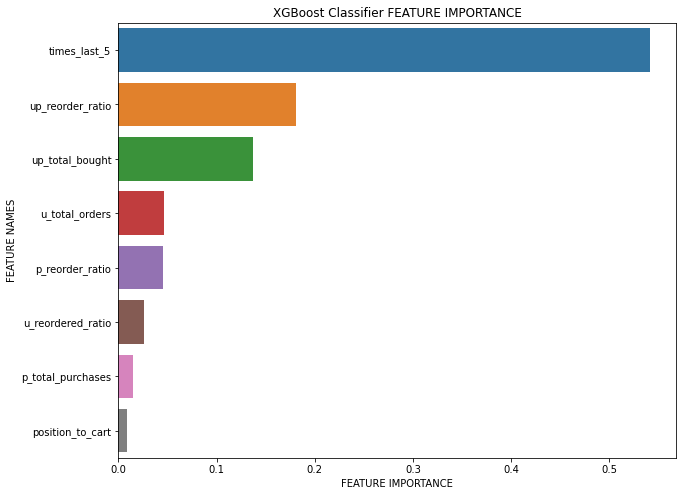

In [55]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
cols = ["up_total_bought", "up_reorder_ratio", "times_last_5", "u_total_orders", "u_reordered_ratio", "p_total_purchases", "p_reorder_ratio",	"position_to_cart"]

plot_feature_importance(xgb_cmodel.feature_importances_,cols,'XGBoost Classifier')

### 5.3 Train Random Forest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
# Select a fitting model without any parameter
rf_cmodel = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = 6, max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0, min_impurity_split = None, min_samples_leaf = 1, min_samples_split = 2, min_weight_fraction_leaf = 0.0,n_estimators = 20, n_jobs = -1, oob_score = False, random_state = 50, verbose = 0, warm_start = False)
rf_cmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=20, n_jobs=-1, random_state=50)

In [58]:
train_pred2 = (rf_cmodel.predict_proba(X_train)[:, 1] >= 0.21).astype(int)
train_pred2[:5]

array([0, 1, 0, 0, 0])

In [59]:
test_pred2 = (rf_cmodel.predict_proba(X_test)[:, 1] >= 0.21).astype(int)
test_pred2[:5]

array([0, 0, 1, 0, 0])

In [60]:
# Confusion Matrix
metrics.confusion_matrix(test_pred2, y_test)

# Get f1 score and classification report
print(f'f1 Score: {f1_score(train_pred2, y_train)}')
print(classification_report(train_pred2, y_train))

print(f'f1 Score: {f1_score(test_pred2, y_test)}')
print(classification_report(test_pred2, y_test))

f1 Score: 0.30968505725337586
              precision    recall  f1-score   support

           0       0.96      0.95      0.96   8777127
           1       0.30      0.32      0.31    538440

    accuracy                           0.92   9315567
   macro avg       0.63      0.64      0.63   9315567
weighted avg       0.92      0.92      0.92   9315567

f1 Score: 0.30891471413619553
              precision    recall  f1-score   support

           0       0.96      0.95      0.96   3761654
           1       0.30      0.32      0.31    230732

    accuracy                           0.92   3992386
   macro avg       0.63      0.64      0.63   3992386
weighted avg       0.92      0.92      0.92   3992386



In [61]:
res_clm2 = pd.DataFrame(data=[["Random Forest Classifier",*eval_class(y_train, train_pred2),
                                 *eval_class(y_test, test_pred2)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm = res_clm.append(res_clm2, ignore_index=True)
res_clm[dis_clm]

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test,Log_loss_test,AUC_test
0,XGBoost Classifier,0.913776,0.913437,0.313900,0.327623,0.320615,2.989817,0.640005
1,Random Forest Classifier,0.917126,0.916975,0.321078,0.297639,0.308915,2.867615,0.627897


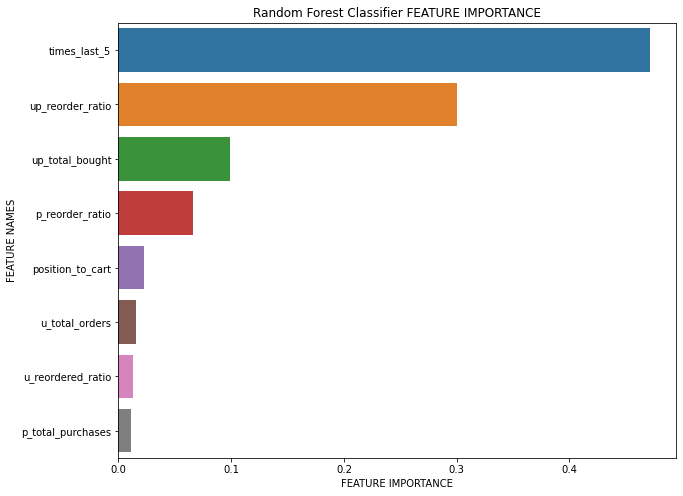

In [62]:
plot_feature_importance(rf_cmodel.feature_importances_,cols,'Random Forest Classifier')

In [63]:
import pickle

# save model to pickle file
pickle.dump(xgb_cmodel, open("xgb_cmodel.pkl", "wb"))

In [64]:
pickle.dump(rf_cmodel, open("rf_cmodel.pkl", "wb"))